In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/949.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/949.2 kB ? eta -:--:--
     ------------------- ---------------- 524.3/949.2 kB 796.8 kB/s eta 0:00:01
     ----------------------------- ------ 786.4/949.2 kB 780.2 kB/s eta 0:00:01
     ------------------------------------ 949.2/949.2 kB 771.1 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

In [3]:
# Download AAPL data using yfinance
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2025-09-03', progress=False)
data.to_csv('AAPL.csv')  # Save to CSV
print("AAPL.csv has been saved in your working directory.")

C:\Users\SUBHANUDDIN\AppData\Local\Temp\ipykernel_2540\1122497408.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2025-09-03', progress=False)


AAPL.csv has been saved in your working directory.


In [9]:
# Function to load and clean the CSV
def load_and_clean_csv(file_path):
    try:
        # Read CSV with explicit handling of bad lines
        data = pd.read_csv(file_path, on_bad_lines='skip')
        print("Raw data head:")
        print(data.head())

        # Skip metadata rows (e.g., 'Ticker', 'AAPL')
        if any(data.iloc[0].astype(str).str.contains('Ticker|AAPL', case=False, na=False)):
            print("Detected metadata in first rows, skipping...")
            data = data.iloc[2:].reset_index(drop=True)

        # Ensure columns are correctly assigned
        expected_columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Open', 'Volume']
        if not all(col in data.columns for col in ['Date', 'Close']):
            print("Columns misaligned, attempting to fix...")
            data.columns = expected_columns[:len(data.columns)]  # Assign expected columns

        # Convert 'Date' to datetime and 'Close' to numeric
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

        # Drop rows with NaN in 'Date' or 'Close'
        data = data.dropna(subset=['Date', 'Close'])

        # Sort by date
        data = data.sort_values('Date')

        print("Cleaned data head:")
        print(data[['Date', 'Close']].head())

        return data['Close'].values.reshape(-1, 1)

    except Exception as e:
        print(f"Error loading/cleaning CSV: {e}")
        print("Falling back to yfinance to download AAPL data...")
        ticker = 'AAPL'
        data = yf.download(ticker, start='2000-01-01', end='2025-09-03', progress=False)
        data.to_csv('AAPL_clean.csv')  # Save clean data
        print("Downloaded and saved clean data as AAPL_clean.csv")
        return data['Close'].values.reshape(-1, 1)

In [10]:
# Load and clean data
closing_prices = load_and_clean_csv('AAPL.csv')

Raw data head:
        Price               Close                High                 Low  \
0      Ticker                AAPL                AAPL                AAPL   
1        Date                 NaN                 NaN                 NaN   
2  2015-01-02  24.261049270629883  24.729272337596463   23.82167345251905   
3  2015-01-05  23.577573776245117  24.110149898969926  23.391173064448488   
4  2015-01-06   23.57979393005371   23.83942422525078  23.218085117057225   

                 Open     Volume  
0                AAPL       AAPL  
1                 NaN        NaN  
2   24.71817633026032  212818400  
3  24.030263395910563  257142000  
4  23.641927502270494  263188400  
Detected metadata in first rows, skipping...
Columns misaligned, attempting to fix...
Cleaned data head:
        Date      Close
0 2015-01-02  24.729272
1 2015-01-05  24.110150
2 2015-01-06  23.839424
3 2015-01-07  24.010290
4 2015-01-08  24.886819


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [13]:
# Set sequence length
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [14]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [15]:
# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

C:\Users\SUBHANUDDIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 0.0079 - val_loss: 7.2992e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0010 - val_loss: 5.2164e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 9.0449e-04 - val_loss: 7.0417e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7.3785e-04 - val_loss: 6.6483e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 7.1039e-04 - val_loss: 0.0014
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.7500e-04 - val_loss: 4.7495e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 6.5420e-04 - val_loss: 8.4090e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 5.9480e-04 - val_loss: 4.9929e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.6616e-04 - val_loss: 4.2306e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 5.5685e-04 - val_loss: 4.1203e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 5.7201e-04 - val_los

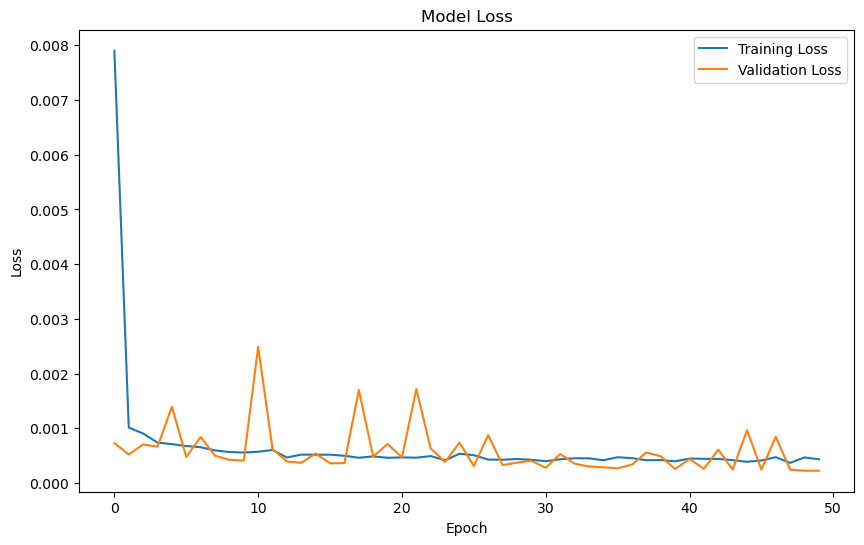

In [19]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()